In [8]:
#importing the libraries
import pandas as pd
import re
import nltk

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [56]:
# Reading the tab-separated file

texts = pd.read_csv("SMSSpamCollection/SMSSpamCollection", sep = "\t", names = ["label", "message"])

# Above we are reading the file SMSSpamCollection from the folder SMSSpamCollection which is in the same folder as the notebook
# sep is the separater we have between the labels, which appears first and named label column, and then message
print(texts)
print(texts["label"].count())

#finding out the number of spam, ham and the percentage of their occrance
label_counts = texts["label"].value_counts()
print(label_counts)

# Percentage of spam
print(f"Spam percentage is {100*(label_counts["spam"]/(texts["label"].count()))} %")


     label                                            message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
...    ...                                                ...
5567  spam  This is the 2nd time we have tried 2 contact u...
5568   ham               Will ü b going to esplanade fr home?
5569   ham  Pity, * was in mood for that. So...any other s...
5570   ham  The guy did some bitching but I acted like i'd...
5571   ham                         Rofl. Its true to its name

[5572 rows x 2 columns]
5572
label
ham     4825
spam     747
Name: count, dtype: int64
Spam percentage is 13.406317300789663 %


In [66]:
#Data cleaning and pre-processing

lm = WordNetLemmatizer()
corpus = [] #creating a corpus containing entirely of only the messages, not the labels

for i in range(len(texts)):
    review = re.sub("[^a-zA-Z]", " ", texts["message"][i])
    review = review.lower()
    review = review.split(" ")
    #Lemmatizing using list comprehension and stopwords:
    review = [lm.lemmatize(word) for word in review if word not in set(stopwords.words("english"))]
    review = " ".join(review)
    corpus.append(review)

# print(corpus)

In [76]:
#Creating Bag-of-words model
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features = 5000) #vectorizer will only consider the top 5000 most frequent words (or tokens). 
#Any words beyond the 5000 most common will be ignored

X = cv.fit_transform(corpus).toarray()

X.shape 

(5572, 5000)

In [82]:
#converting the labels into 0,1 values
y = pd.get_dummies(texts['label']) # converting the label column of texts into 2 different columns, like one hot encoding

#first, we choose all rows by :
#Then we select the second column of y by 1 so that when spam, 1 appears, and when ham, 0 appears
#.values change it from pandas series to numpy array
y = y.iloc[:, 1].values 

<class 'numpy.ndarray'>


In [86]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 420)

#80% training data, 20% test data, seed = 420 for reusability purpose

In [90]:
#Training the model using Naive Bayes classifier
from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB().fit(X_train, y_train)

#prediction on test data
y_pred = spam_detect_model.predict(X_test)

#Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print(cm)

[[953  15]
 [  3 144]]


In [92]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Extracting TP, TN, FP, FN from the confusion matrix
TP = cm[1, 1]  # True Positives
TN = cm[0, 0]  # True Negatives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives

# Calculating precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision}')

# Calculating recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall}')

# Calculating F1 Score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

# Calculating Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


Precision: 0.9056603773584906
Recall: 0.9795918367346939
F1 Score: 0.9411764705882353
Accuracy: 0.9838565022421525


AUC-ROC: 0.998327430145612


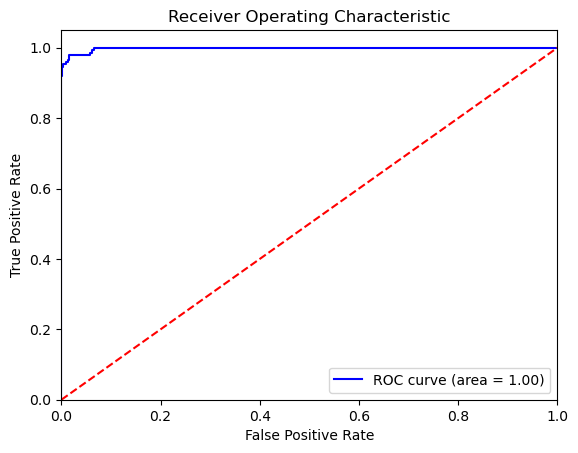

In [98]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Getting predicted probabilities for the positive class
y_prob = spam_detect_model.predict_proba(X_test)[:, 1]  # Probability of the positive class

# Calculating AUC-ROC
roc_auc = roc_auc_score(y_test, y_prob)
print(f'AUC-ROC: {roc_auc}')

# Plotting the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# Model Performance Metrics Interpretation

Interpreting the performance metrics in the context of an imbalanced dataset (14% spam and 86% ham) provides valuable insights into how well the model is performing. Let's analyze each of the provided metrics in detail:

## 1. Precision: **0.9057** (approximately 90.57%)

- **Interpretation**: Precision is the proportion of predicted positive cases (spam) that are actually positive. A precision of 90.57% indicates that when the model predicts a message as spam, it is correct about 90.57% of the time.
- **Implications**: This is a relatively high precision score, suggesting that the model is effective at identifying spam and minimizing false positives (ham misclassified as spam). In a spam detection context, this is important because users generally prefer not to have legitimate emails incorrectly marked as spam.

## 2. Recall: **0.9796** (approximately 97.96%)

- **Interpretation**: Recall measures the proportion of actual positive cases (spam) that were correctly identified by the model. A recall of 97.96% means that the model successfully identifies nearly all the spam emails.
- **Implications**: This indicates that the model is very effective at catching spam, with very few false negatives (spam misclassified as ham). In the context of spam detection, a high recall is critical, as missing spam emails can have negative consequences for users.

## 3. F1 Score: **0.9412** (approximately 94.12%)

- **Interpretation**: The F1 score is the harmonic mean of precision and recall, balancing the two metrics. An F1 score of 94.12% suggests that the model has a good balance between precision and recall.
- **Implications**: A high F1 score indicates that the model performs well on both fronts—it's not just catching spam (high recall) but also doing so with a relatively low rate of false alarms (high precision). In scenarios where both false positives and false negatives are costly (e.g., spam detection), this metric is particularly useful.

## 4. Accuracy: **0.9839** (approximately 98.39%)

- **Interpretation**: Accuracy is the proportion of total correct predictions (both spam and ham) out of all predictions made. An accuracy of 98.39% indicates that the model correctly identifies a vast majority of messages.
- **Implications**: While this accuracy is impressive, it's important to consider the class imbalance in the dataset. Given that 86% of the messages are ham, a model that simply predicts all messages as ham could achieve high accuracy but would fail at identifying any spam. Therefore, accuracy alone may not be a reliable measure of model performance in this context.

## Summary and Model Performance

Overall, the model exhibits strong performance in terms of precision, recall, and F1 score, suggesting it is well-suited for the task of spam detection:

- **High Precision**: Indicates low false positive rate, which is crucial for user satisfaction.
- **High Recall**: Indicates low false negative rate, meaning the model is effective at catching spam.
- **High F1 Score**: Indicates a good balance between precision and recall, making it reliable in a critical application like spam detection.

However, while accuracy is high, it should be interpreted cautiously due lt threshold of 0.5 may not be optimal.

In conclusion, the model shows great promise for practical spam detection applications while remaining mindful of the imbalanced nature of the dataset.

---

# AUC-ROC Score Interpretation

The AUC-ROC score of **0.9983** (approximately 99.83%) is an outstanding result and offers significant insights into the goodness of your spam detection model. Here’s how to interpret this score and what it means for the model's performance:

## Understanding AUC-ROC

**AUC (Area Under the Curve)**: This metric represents the area under the ROC curve, which is a plot of the true positive rate (sensitivity or recall) against the false positive rate (1 - specificity) at various threshold settings. The AUC score ranges from 0 to 1:

- **AUC = 0.5**: The model has no discrimination ability (equivalent to random guessing).
- **AUC < 0.5**: The model performs worse than random guessing.
- **AUC = 1.0**: The model perfectly classifies all positive and negative cases.

## Interpretation of AUC-ROC = 0.9983

1. **Exceptional Discriminatory Power**: An AUC of 0.9983 indicates that the model has excellent discriminatory ability. It means that there is a 99.83% chance that the model will rank a randomly chosen positive instance (spam) higher than a randomly chosen negative instance (ham). This demonstrates that the model can effectively distinguish between spam and ham with very high confidence.

2. **Robustness Across Thresholds**: The AUC-ROC score captures the model's performance across all possible classification thresholds, not just the default threshold of 0.5. This means that the model performs well regardless of the threshold you choose for making predictions. Such robustness is especially beneficial in practical applications where you may want to adjust the threshold based on the cost of false positives versus false negatives.

3. **Generalization**: A high AUC-ROC suggests that the model is not just memorizing the training data but is generalizing well to unseen data. This is particularly important in spam detection, where new spam patterns may emerge.

4. **Performance in Imbalanced Datasets**: The AUC-ROC metric is especially useful in the context of imbalanced datasets, such as your scenario with 14% spam. It provides a more reliable assessment of performance than accuracy alone, which could be misleading due to class imbalance.

## Insights and Recommendations

- **Model Confidence**: Given the extremely high AUC-ROC, you can be confident in the model's predictions, knowing that it is likely to perform well in a real-world spam detection scenario.

- **Consider Further Testing**: While AUC-ROC is a strong indicator of model performance, it’s also advisable to evaluate other metrics like precision, recall, and F1 score, as you have already done. This helps ensure that the model is not only good at distinguishing classes but also at minimizing false positives and negatives.

- **Monitor in Production**: Once deployed, continue monitoring the model’s performance, as changes in spam tactics can affect its accuracy over time. Regular retraining with updated data can help maintain its effectiveness.

- **Threshold Adjustment**: Depending on the application, consider adjusting the classification threshold to optimize precision and recall based on business requirements or user preferences. For example, if false positives are particularly costly (i.e., legitimate emails marked as spam), you might choose a higher threshold.

## Conclusion

In summary, an AUC-ROC score of **0.9983** reflects a highly effective spam detection model with excellent capability to differentiate between spam and ham emails. The model is not only reliable but also robust across different scenarios and thresholds, making it well-suited for practical deployment in spam detection applications.
